In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics
from collections import Counter
import torchvision.datasets as datasets
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import pandas as pd
import optuna
from optuna.trial import TrialState
import os
import pickle

/home/uottawa.o.univ/sadin008/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=(256, 256), antialias=True),
    transforms.Resize((256, 256)), # Resize all images to a uniform size (e.g., 64x64 pixels)
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor (0-255 to 0.0-1.0)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize pixel values
    transforms.RandomHorizontalFlip(p=0.5)
    
])

In [5]:


train_dir = 'real-vs-fake/train' 
test_dir = 'real-vs-fake/test' 
val_dir = 'real-vs-fake/val' 

train_dataset=torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset=torchvision.datasets.ImageFolder(root=val_dir, transform=transform)




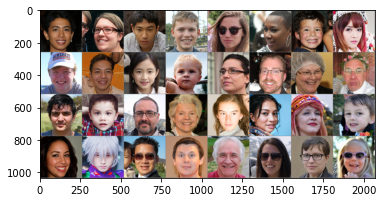

In [6]:
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

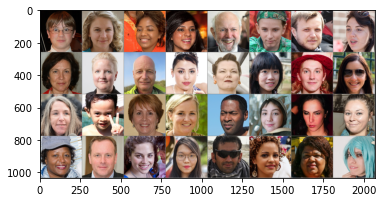

In [7]:

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

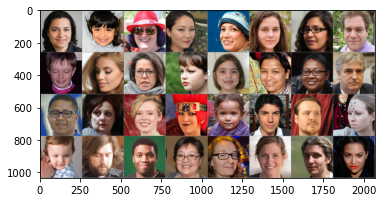

In [8]:

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True, # Shuffle data for training
    num_workers=2 # Use multiple subprocesses for data loading 
)

# get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


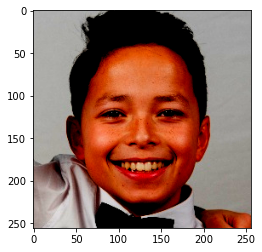

torch.Size([3, 256, 256])

In [9]:
#Sanity check (set shuffle=False in loader so order in file explorer is perserved)
index=0
npimg=train_loader.dataset[index][0].numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_loader.dataset[index][1]

img, label=train_loader.dataset[index]
img.size()


In [10]:
# Calculate the class distribution
train_distribution = Counter(train_dataset.targets)
print(f"Train distribution: {train_distribution}")

# Calculate the class distribution
val_distribution = Counter(val_dataset.targets)
print(f"Validation distribution: {val_distribution}")

# Calculate the class distribution
test_distribution = Counter(test_dataset.targets)
print(f"Test distribution: {test_distribution}")



Train distribution: Counter({0: 8620, 1: 7565})
Validation distribution: Counter({1: 2694, 0: 2655})
Test distribution: Counter({0: 3143, 1: 3048})


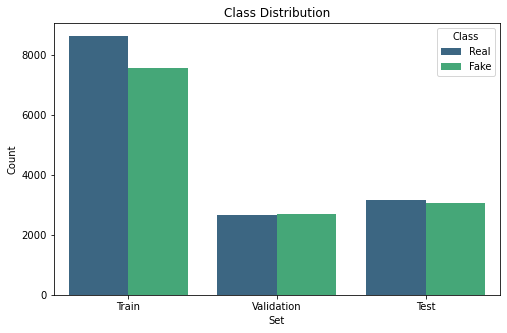

In [11]:
#https://www.kaggle.com/code/skshitij/deepfake-detection
data_counts = {
    'Set': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['Real', 'Fake', 'Real', 'Fake', 'Real', 'Fake'],
    'Count': [train_distribution[0], train_distribution[1],
              val_distribution[0], val_distribution[1],
              test_distribution[0], test_distribution[1]]
}

df_counts = pd.DataFrame(data_counts)

plt.figure(figsize=(8,5))
sns.barplot(x="Set", y="Count", hue="Class", data=df_counts, palette="viridis")
plt.title("Class Distribution")
plt.show()


<h2>CNN</h2>

In [12]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes, l1=256):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # dropout layer
       self.dropout1 = nn.Dropout(0.2)
       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # 2nd convolutional layer
       self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
       # Fully connected layers
       self.fc1 = nn.Linear(32 * 32 * 32, l1)
       self.fc2 = nn.Linear(l1, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv3(x))  # Apply second convolution and ReLU activation
       x = self.dropout1(x)       # dropout
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       x = self.fc2(x)            # Apply fully connected layer
       return x
    


In [24]:

def baseline_cnn():
    # Generate the model.
    model = CNN(in_channels=3, num_classes=1).to(device)
    
    # Define the loss function
    criterion = nn.BCEWithLogitsLoss() 
    
    # Generate the optimizers.

    optimizer = optim.Adam(model.parameters())

    # Training of the model.
    num_epochs=10

    train_loss_plots=np.zeros(num_epochs) # for visualization plots
    val_loss_plots=np.zeros(num_epochs) # for visualization plots

    for epoch in range(num_epochs):
    # Iterate over training batches
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        
        running_loss=0.0
        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        epoch_train_loss=running_loss/len(train_loader)
        train_loss_plots[epoch]=epoch_train_loss
        
        acc = torchmetrics.Accuracy(task="binary").to(device)
        acc.reset()
        valid_loss = 0.0
        correct=0.0
        total=0.0
        model.eval()     
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)


            probabilities = torch.sigmoid(scores)
            predicted_classes = (probabilities > 0.5).float()
            
            total += targets.size(0)
            correct += (predicted_classes == targets).sum().item()
            
            loss = criterion(scores, targets)
            valid_loss += loss.item()
            
        epoch_valid_loss=valid_loss/len(val_loader)
        val_loss_plots[epoch]=epoch_valid_loss
        
        print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
        print('---------------------------------------------')

        accuracy = correct / total
baseline_cnn()

Epoch [1/10]


100%|██████████| 168/168 [00:09<00:00, 18.51it/s]


Epoch 1 Results[ Training Loss: 0.649518685790861, Validation Loss: 0.6021220605997812 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:09<00:00, 17.86it/s]


Epoch 2 Results[ Training Loss: 0.5418541041523101, Validation Loss: 0.5885520776112875 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:09<00:00, 18.39it/s]


Epoch 3 Results[ Training Loss: 0.46145257218317554, Validation Loss: 0.4514782147570735 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:09<00:00, 18.00it/s]


Epoch 4 Results[ Training Loss: 0.40174754767903226, Validation Loss: 0.43131831838261514 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:09<00:00, 17.79it/s]


Epoch 5 Results[ Training Loss: 0.3454849390173147, Validation Loss: 0.3791629143414043 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:09<00:00, 18.35it/s]


Epoch 6 Results[ Training Loss: 0.30081321739337663, Validation Loss: 0.38214862665959765 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:09<00:00, 18.03it/s]


Epoch 7 Results[ Training Loss: 0.2641840801011079, Validation Loss: 0.36348758456075475 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:08<00:00, 18.95it/s]


Epoch 8 Results[ Training Loss: 0.22622427914895324, Validation Loss: 0.37627332373743966 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:09<00:00, 17.44it/s]


Epoch 9 Results[ Training Loss: 0.19573444640816082, Validation Loss: 0.36105791355172795 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:09<00:00, 18.34it/s]

Epoch 10 Results[ Training Loss: 0.17654694112849684, Validation Loss: 0.3694704547857067 ]
---------------------------------------------


<h3>Objective Function(Training)</h3>

In [13]:
base_path = "./artifacts"
os.makedirs(base_path, exist_ok=True)
artifact_store = optuna.artifacts.FileSystemArtifactStore(base_path=base_path)
def objective(trial):
    
    # Generate the model.
    model = CNN(in_channels=3, num_classes=1).to(device)
    
    # Define the loss function
    criterion = nn.BCEWithLogitsLoss() 
    
    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    optimizer = optim.SGD(vgg_model.parameters(), lr=lr, weight_decay=decay, momentum=0.9)

    # Training of the model.
    num_epochs=10

    train_loss_plots=np.zeros(num_epochs) # for visualization plots
    val_loss_plots=np.zeros(num_epochs) # for visualization plots

    for epoch in range(num_epochs):
    # Iterate over training batches
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        # TRAINING
        running_loss=0.0
        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        epoch_train_loss=running_loss/len(train_loader)
        train_loss_plots[epoch]=epoch_train_loss

        # VALIDATION
        valid_loss = 0.0
        correct=0.0
        total=0.0
        model.eval()     
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)


            probabilities = torch.sigmoid(scores)
            predicted_classes = (probabilities > 0.5).float()
            
            total += targets.size(0)
            correct += (predicted_classes == targets).sum().item()
            
            loss = criterion(scores, targets)
            valid_loss += loss.item()
            
        epoch_valid_loss=valid_loss/len(val_loader)
        val_loss_plots[epoch]=epoch_valid_loss
        
        print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
        print('---------------------------------------------')

        accuracy = correct / total
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    
    # Save the model using ArtifactStore
    with open("model.pickle", "wb") as fout:
        pickle.dump(model, fout)
    artifact_id = optuna.artifacts.upload_artifact(
        artifact_store=artifact_store,
        file_path="model.pickle",
        study_or_trial=trial.study,
    )
    trial.set_user_attr("artifact_id", artifact_id)
    
    # Store training/validation loss for plots
    trial.set_user_attr("train_loss", train_loss_plots)
    trial.set_user_attr("val_loss", val_loss_plots)
    
    
    return accuracy


<h3>Hyperparameter Tuning</h3>

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)



[I 2025-12-02 18:23:37,505] A new study created in memory with name: no-name-f33bc48e-8538-4f7c-b9d2-1e11900b4f15


Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 19.14it/s]


Epoch 1 Results[ Training Loss: 0.713743647803431, Validation Loss: 0.6956744563011896 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 19.14it/s]


Epoch 2 Results[ Training Loss: 0.6911976405754391, Validation Loss: 0.6964395415215265 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 19.00it/s]


Epoch 3 Results[ Training Loss: 0.6912737209570737, Validation Loss: 0.6941765202652841 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:08<00:00, 19.17it/s]


Epoch 4 Results[ Training Loss: 0.6913574882175612, Validation Loss: 0.6954107241971152 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 19.03it/s]


Epoch 5 Results[ Training Loss: 0.6912595662674885, Validation Loss: 0.69523945273388 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:08<00:00, 18.91it/s]


Epoch 6 Results[ Training Loss: 0.6912851537404795, Validation Loss: 0.6953133543332418 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 19.09it/s]


Epoch 7 Results[ Training Loss: 0.7822364071612301, Validation Loss: 0.6932069687616258 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:08<00:00, 18.93it/s]


Epoch 8 Results[ Training Loss: 0.7467763891568768, Validation Loss: 0.6969945146923974 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.83it/s]


Epoch 9 Results[ Training Loss: 0.6913104462529359, Validation Loss: 0.6958270321289698 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.72it/s]
[I 2025-12-02 18:30:00,334] Trial 0 finished with value: 0.4963544587773416 and parameters: {'optimizer': 'Adam', 'lr': 0.013580550744055625, 'weight_decay': 0.017925084375891853}. Best is trial 0 with value: 0.4963544587773416.


Epoch 10 Results[ Training Loss: 0.6913059323201538, Validation Loss: 0.6954322003182911 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:09<00:00, 18.66it/s]


Epoch 1 Results[ Training Loss: 0.6909189794374548, Validation Loss: 0.694762834126041 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 18.91it/s]


Epoch 2 Results[ Training Loss: 0.6904194382104006, Validation Loss: 0.6956495749098914 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]


Epoch 3 Results[ Training Loss: 0.6901013645023225, Validation Loss: 0.6952473631217366 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:09<00:00, 18.59it/s]


Epoch 4 Results[ Training Loss: 0.6897722735942117, Validation Loss: 0.6948015892079898 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:09<00:00, 18.51it/s]


Epoch 5 Results[ Training Loss: 0.6894493768573279, Validation Loss: 0.6949413922571 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:09<00:00, 18.52it/s]


Epoch 6 Results[ Training Loss: 0.689096707482583, Validation Loss: 0.6938276567629406 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:09<00:00, 18.44it/s]


Epoch 7 Results[ Training Loss: 0.688730385699291, Validation Loss: 0.6939095996675038 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:09<00:00, 18.56it/s]


Epoch 8 Results[ Training Loss: 0.6882658514816299, Validation Loss: 0.6927184735735258 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:09<00:00, 18.52it/s]


Epoch 9 Results[ Training Loss: 0.6878988773455261, Validation Loss: 0.6928259003020468 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:09<00:00, 18.47it/s]
[I 2025-12-02 18:36:27,925] Trial 1 finished with value: 0.4963544587773416 and parameters: {'optimizer': 'SGD', 'lr': 0.0003188808834123082, 'weight_decay': 0.00014508417071373253}. Best is trial 0 with value: 0.4963544587773416.


Epoch 10 Results[ Training Loss: 0.6874210017000734, Validation Loss: 0.6927224018034481 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.75it/s]


Epoch 1 Results[ Training Loss: 149.56114098205867, Validation Loss: 0.7118349327217965 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 18.81it/s]


Epoch 2 Results[ Training Loss: 0.7488642921560837, Validation Loss: 0.7153785331618219 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 18.79it/s]


Epoch 3 Results[ Training Loss: 0.7673879403606234, Validation Loss: 0.8383169720570246 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:09<00:00, 18.64it/s]


Epoch 4 Results[ Training Loss: 0.772594910129728, Validation Loss: 0.7141460925340652 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:09<00:00, 18.62it/s]


Epoch 5 Results[ Training Loss: 0.7597092686905691, Validation Loss: 0.7397922752868562 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:08<00:00, 18.80it/s]


Epoch 6 Results[ Training Loss: 0.7762497427906443, Validation Loss: 0.7868438121818361 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 19.02it/s]


Epoch 7 Results[ Training Loss: 5.477172152326983, Validation Loss: 0.6974553976740155 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:08<00:00, 18.90it/s]


Epoch 8 Results[ Training Loss: 0.715179379749675, Validation Loss: 0.7071971126965114 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 19.12it/s]


Epoch 9 Results[ Training Loss: 0.7232762929714716, Validation Loss: 0.7298146127944901 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]
[I 2025-12-02 18:42:51,914] Trial 2 finished with value: 0.4963544587773416 and parameters: {'optimizer': 'Adam', 'lr': 0.06818060184416595, 'weight_decay': 0.0003052686585556238}. Best is trial 0 with value: 0.4963544587773416.


Epoch 10 Results[ Training Loss: 1.9682338467464144, Validation Loss: 0.7473237631576402 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 19.05it/s]


Epoch 1 Results[ Training Loss: 0.685182761651254, Validation Loss: 0.6792538921747889 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 18.72it/s]


Epoch 2 Results[ Training Loss: 0.6574073711873986, Validation Loss: 0.6503698575709548 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]


Epoch 3 Results[ Training Loss: 0.6306136149191574, Validation Loss: 0.6260472678002857 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:08<00:00, 18.96it/s]


Epoch 4 Results[ Training Loss: 0.6146571749283862, Validation Loss: 0.6159834159272057 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 19.10it/s]


Epoch 5 Results[ Training Loss: 0.6046783263857657, Validation Loss: 0.6107562319153831 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:08<00:00, 18.83it/s]


Epoch 6 Results[ Training Loss: 0.5971914404347951, Validation Loss: 0.6053063846414998 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 18.95it/s]


Epoch 7 Results[ Training Loss: 0.5905541233983436, Validation Loss: 0.6003692792285056 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:09<00:00, 18.41it/s]


Epoch 8 Results[ Training Loss: 0.5816662927625679, Validation Loss: 0.6218185314819926 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.92it/s]


Epoch 9 Results[ Training Loss: 0.572043726979037, Validation Loss: 0.5972551107406616 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.77it/s]
[I 2025-12-02 18:49:11,923] Trial 3 finished with value: 0.6765750607590204 and parameters: {'optimizer': 'SGD', 'lr': 0.004621009534073626, 'weight_decay': 0.00790709014907342}. Best is trial 3 with value: 0.6765750607590204.


Epoch 10 Results[ Training Loss: 0.5655133577556949, Validation Loss: 0.600431690436034 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.76it/s]


Epoch 1 Results[ Training Loss: 0.6922342498076292, Validation Loss: 0.6930914595723152 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:09<00:00, 18.43it/s]


Epoch 2 Results[ Training Loss: 0.6914627719302422, Validation Loss: 0.6934968045070058 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:09<00:00, 18.58it/s]


Epoch 3 Results[ Training Loss: 0.6909554680816741, Validation Loss: 0.6939517766946838 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:09<00:00, 18.31it/s]


Epoch 4 Results[ Training Loss: 0.6906623653036804, Validation Loss: 0.6942644874964442 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:09<00:00, 18.37it/s]


Epoch 5 Results[ Training Loss: 0.6904941534571968, Validation Loss: 0.6943792172131085 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:09<00:00, 18.56it/s]


Epoch 6 Results[ Training Loss: 0.6903448055384187, Validation Loss: 0.6946688940127691 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 18.68it/s]


Epoch 7 Results[ Training Loss: 0.6902908164521923, Validation Loss: 0.6945062120045934 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:09<00:00, 18.38it/s]


Epoch 8 Results[ Training Loss: 0.6901714609781273, Validation Loss: 0.694761821556659 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.72it/s]


Epoch 9 Results[ Training Loss: 0.6900748727114304, Validation Loss: 0.6947794535330364 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:09<00:00, 18.51it/s]
[I 2025-12-02 18:55:37,762] Trial 4 finished with value: 0.4963544587773416 and parameters: {'optimizer': 'SGD', 'lr': 8.508922059967682e-05, 'weight_decay': 2.778332615120991e-05}. Best is trial 3 with value: 0.6765750607590204.


Epoch 10 Results[ Training Loss: 0.6899762208989486, Validation Loss: 0.6946561077520961 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.91it/s]


Epoch 1 Results[ Training Loss: 0.6475121216340498, Validation Loss: 0.6265565270469302 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:09<00:00, 18.37it/s]


Epoch 2 Results[ Training Loss: 0.6093692421441964, Validation Loss: 0.6695224220554034 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:09<00:00, 18.39it/s]


Epoch 3 Results[ Training Loss: 0.590197371812206, Validation Loss: 0.6104658948523658 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:09<00:00, 18.63it/s]


Epoch 4 Results[ Training Loss: 0.572446000140175, Validation Loss: 0.5884313766090643 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 18.76it/s]


Epoch 5 Results[ Training Loss: 0.5555587529311539, Validation Loss: 0.5864208518039613 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:09<00:00, 18.36it/s]


Epoch 6 Results[ Training Loss: 0.5527234174046121, Validation Loss: 0.5531325340270996 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:09<00:00, 18.40it/s]


Epoch 7 Results[ Training Loss: 0.5454623861746355, Validation Loss: 0.5493750265311628 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:09<00:00, 18.55it/s]


Epoch 8 Results[ Training Loss: 0.5341676247449731, Validation Loss: 0.5362225685800824 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:09<00:00, 18.45it/s]


Epoch 9 Results[ Training Loss: 0.5291269046986998, Validation Loss: 0.5638506405410313 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:09<00:00, 18.34it/s]
[I 2025-12-02 19:02:04,018] Trial 5 finished with value: 0.7322864086745186 and parameters: {'optimizer': 'SGD', 'lr': 0.03764993057601199, 'weight_decay': 0.02067681902976723}. Best is trial 5 with value: 0.7322864086745186.


Epoch 10 Results[ Training Loss: 0.519846583484661, Validation Loss: 0.5295108437892937 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.82it/s]


Epoch 1 Results[ Training Loss: 0.6519529500262068, Validation Loss: 0.6300421059131622 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 18.98it/s]


Epoch 2 Results[ Training Loss: 0.6135059024976648, Validation Loss: 0.6109592545600164 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:09<00:00, 18.62it/s]


Epoch 3 Results[ Training Loss: 0.5949044370132944, Validation Loss: 0.6759055061709314 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:08<00:00, 18.70it/s]


Epoch 4 Results[ Training Loss: 0.5781162579069025, Validation Loss: 0.5766998435414973 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 18.82it/s]


Epoch 5 Results[ Training Loss: 0.565111998925096, Validation Loss: 0.5675490523378054 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:08<00:00, 18.80it/s]


Epoch 6 Results[ Training Loss: 0.5528690033986163, Validation Loss: 0.5653924910085542 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 18.71it/s]


Epoch 7 Results[ Training Loss: 0.5419228776641514, Validation Loss: 0.5494200922548771 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:09<00:00, 18.59it/s]


Epoch 8 Results[ Training Loss: 0.5332547492778348, Validation Loss: 0.5401020795106888 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.81it/s]


Epoch 9 Results[ Training Loss: 0.5225470578482029, Validation Loss: 0.5906093705977712 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.99it/s]
[I 2025-12-02 19:08:26,217] Trial 6 finished with value: 0.7311647036829314 and parameters: {'optimizer': 'SGD', 'lr': 0.012960815751430795, 'weight_decay': 0.019146677852919233}. Best is trial 5 with value: 0.7322864086745186.


Epoch 10 Results[ Training Loss: 0.5158599384806373, Validation Loss: 0.5287722233860266 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 19.00it/s]


Epoch 1 Results[ Training Loss: 0.6575249462966392, Validation Loss: 0.6451539454006013 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 19.04it/s]


Epoch 2 Results[ Training Loss: 0.6306314638009656, Validation Loss: 0.619635131032694 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]


Epoch 3 Results[ Training Loss: 0.6133216325591204, Validation Loss: 0.6378452400011676 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]


Epoch 4 Results[ Training Loss: 0.5962219463860093, Validation Loss: 0.5982558647436755 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 18.67it/s]


Epoch 5 Results[ Training Loss: 0.5867859594553355, Validation Loss: 0.5843798707993257 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:08<00:00, 19.05it/s]


Epoch 6 Results[ Training Loss: 0.5786630157307674, Validation Loss: 0.5795834029004687 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:08<00:00, 18.93it/s]


Epoch 7 Results[ Training Loss: 0.5683937322480876, Validation Loss: 0.5742144169551986 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:08<00:00, 18.87it/s]


Epoch 8 Results[ Training Loss: 0.5576916766967698, Validation Loss: 0.5768108774153959 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.94it/s]


Epoch 9 Results[ Training Loss: 0.5490125141478339, Validation Loss: 0.5659580672425883 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.85it/s]
[I 2025-12-02 19:14:50,467] Trial 7 finished with value: 0.7038698822209759 and parameters: {'optimizer': 'Adam', 'lr': 0.00020031192964317353, 'weight_decay': 0.018278879147027305}. Best is trial 5 with value: 0.7322864086745186.


Epoch 10 Results[ Training Loss: 0.5433802582294103, Validation Loss: 0.5689615319882121 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 18.89it/s]
[I 2025-12-02 19:15:29,202] Trial 8 pruned. 


Epoch 1 Results[ Training Loss: 3.259706225555405, Validation Loss: 0.6934063580064547 ]
---------------------------------------------
Epoch [1/10]


100%|██████████| 168/168 [00:08<00:00, 19.23it/s]


Epoch 1 Results[ Training Loss: 0.640883569778661, Validation Loss: 0.6087702500323454 ]
---------------------------------------------
Epoch [2/10]


100%|██████████| 168/168 [00:08<00:00, 18.92it/s]


Epoch 2 Results[ Training Loss: 0.5724171966667703, Validation Loss: 0.550661870588859 ]
---------------------------------------------
Epoch [3/10]


100%|██████████| 168/168 [00:08<00:00, 19.34it/s]


Epoch 3 Results[ Training Loss: 0.513911194068641, Validation Loss: 0.5135475047642276 ]
---------------------------------------------
Epoch [4/10]


100%|██████████| 168/168 [00:08<00:00, 19.13it/s]


Epoch 4 Results[ Training Loss: 0.47712605655664514, Validation Loss: 0.47350547338525456 ]
---------------------------------------------
Epoch [5/10]


100%|██████████| 168/168 [00:08<00:00, 18.70it/s]


Epoch 5 Results[ Training Loss: 0.4289254396270386, Validation Loss: 0.4296686519824323 ]
---------------------------------------------
Epoch [6/10]


100%|██████████| 168/168 [00:09<00:00, 18.65it/s]


Epoch 6 Results[ Training Loss: 0.3921913038129392, Validation Loss: 0.4333907850086689 ]
---------------------------------------------
Epoch [7/10]


100%|██████████| 168/168 [00:09<00:00, 17.63it/s]


Epoch 7 Results[ Training Loss: 0.3599864963751301, Validation Loss: 0.402598566065232 ]
---------------------------------------------
Epoch [8/10]


100%|██████████| 168/168 [00:08<00:00, 18.86it/s]


Epoch 8 Results[ Training Loss: 0.32586712510925037, Validation Loss: 0.39089925667004927 ]
---------------------------------------------
Epoch [9/10]


100%|██████████| 168/168 [00:08<00:00, 18.72it/s]


Epoch 9 Results[ Training Loss: 0.2931525510084252, Validation Loss: 0.37157351718772025 ]
---------------------------------------------
Epoch [10/10]


100%|██████████| 168/168 [00:08<00:00, 18.82it/s]
[I 2025-12-02 19:21:50,711] Trial 9 finished with value: 0.8179098896990091 and parameters: {'optimizer': 'SGD', 'lr': 0.06470929136609627, 'weight_decay': 3.1675370956431755e-05}. Best is trial 9 with value: 0.8179098896990091.


Epoch 10 Results[ Training Loss: 0.26942560871834814, Validation Loss: 0.4311517422486629 ]
---------------------------------------------


In [15]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  1
  Number of complete trials:  9
Best trial:
  Value:  0.8179098896990091
  Params: 
    optimizer: SGD
    lr: 0.06470929136609627
    weight_decay: 3.1675370956431755e-05


In [16]:
#Save the best model from the ae
best_artifact_id = trial.user_attrs["artifact_id"]
best_model_path=f"model_{best_artifact_id}.pickle"
optuna.artifacts.download_artifact(
    artifact_store=artifact_store,
    file_path=best_model_path,
    artifact_id=best_artifact_id,
)

In [17]:
# Load tuned model
best_model = CNN(in_channels=3, num_classes=2)
with open(best_model_path, 'rb') as file:  
    best_model = pickle.load(file)

<h3>Evaluation</h3>

In [18]:
# Accuracy metric
acc = torchmetrics.Accuracy(task="binary").to(device)

# Iterate over the dataset batches
acc.reset()
best_model.eval()
probabilities=[]
y_pred_cnn=[]
y_true_cnn=[]
correct=0.0
total=0.0
with torch.no_grad():
   for images, labels in test_loader:
        y_true_cnn.extend(labels)
        # Get predicted probabilities for test data batch
        
        labels = labels.float().view(-1, 1)
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        probs = torch.sigmoid(outputs)
        predicted_classes = (probs > 0.5).float()
        probabilities.extend(probs)
        
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()
        #probabilities.extend(outputs[:,1])
        #_, preds = torch.max(outputs, 1)
        acc.update(outputs, labels)
        y_pred_cnn.extend(predicted_classes)
        
        

#Compute total test accuracy
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.819415271282196


<h3>CNN Results Visualization</h3>

In [19]:
# Moving variables to cpu
preds=torch.tensor(y_pred_cnn).cpu()
trues=torch.tensor(y_true_cnn).cpu()
probs=torch.tensor(probabilities).cpu()

In [20]:
#Classification report
print(classification_report(trues, preds))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84      3143
           1       0.91      0.71      0.79      3048

    accuracy                           0.82      6191
   macro avg       0.84      0.82      0.82      6191
weighted avg       0.84      0.82      0.82      6191



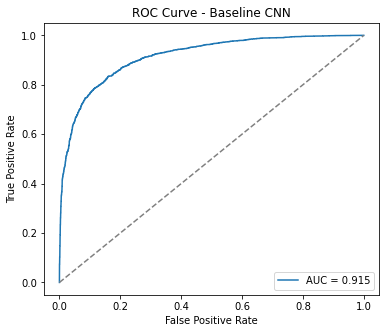

In [21]:
#ROC curves
fpr, tpr, thresholds = roc_curve(trues, probs)
roc_auc = roc_auc_score(trues, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.plot([0,1],[0,1], '--', color="gray")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline CNN')
plt.legend(loc='lower right')
plt.show()


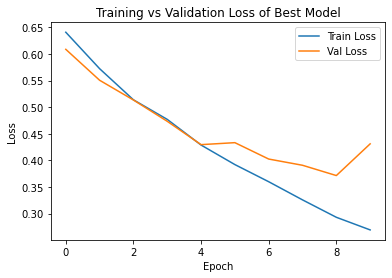

In [22]:
#Validation vs Training Loss
plt.plot(trial.user_attrs['train_loss'], label='Train Loss')
plt.plot(trial.user_attrs['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss of Best Model")
plt.legend()
plt.show()

<h2> VGG Model </h2>

<h3> Objective Function (Training)</h3>

In [32]:
def objective_vgg(trial):
    # --- Configuring the VGG Model for Binary Classification ---
    # (num of output classes for binary classification is 1)
    num_classes = 1
    
    # Load a pre-trained VGG16 model with default weights
    vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # Modify the final fully connected layer to match the single output class
    num_features = vgg_model.classifier[-1].in_features
    vgg_model.classifier[-1] = nn.Linear(num_features, num_classes)
    
    # Move the model to GPU if available
    vgg_model.to(device)
    
    print(f"VGG model configured for binary classification, running on {device}")
    
    # --- Define Loss Function and Optimizer for Binary Classification ---
    
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) # Hyperparameter tuning
    decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    
    criterion = nn.BCEWithLogitsLoss() # use for "numerical stability"
    optimizer = optim.SGD(vgg_model.parameters(), lr=lr, weight_decay=decay, momentum=0.9)
    
    # --- The Training Loop!!! ---
    NUM_EPOCHS = 3
    
    print("Starting Training...")
    for epoch in range(NUM_EPOCHS):
        vgg_model.train() # Set model to training mode
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            # Ensure labels are type float and have shape [batch_size, 1]
            labels = labels.float().view(-1, 1)
            
            inputs, labels = inputs.to(device), labels.to(device)
    
            # Zero the gradients
            optimizer.zero_grad()
    
            # Forward pass: Plug inputs into the VGG model
            outputs = vgg_model(inputs)
            
            # Calculate loss using the binary criteria
            loss = criterion(outputs, labels)
    
            # Backward pass +optimize
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

        #--- Validation ---
 
        valid_loss = 0.0
        correct=0.0
        total=0.0
        vgg_model.eval()     
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            targets = targets.float().view(-1, 1)
            data = data.to(device)
            targets = targets.to(device)
            scores = vgg_model(data)


            probabilities = torch.sigmoid(scores)
            predicted_classes = (probabilities > 0.5).float()
            
            total += targets.size(0)
            correct += (predicted_classes == targets).sum().item()
            
            loss = criterion(scores, targets)
            valid_loss += loss.item()
            
        epoch_valid_loss=valid_loss/len(val_loader)
        val_loss_plots[epoch]=epoch_valid_loss
        
        print(f'Epoch {epoch+1} Results[ Training Loss: {epoch_train_loss}, Validation Loss: {epoch_valid_loss} ]')
        print('---------------------------------------------')

        accuracy = correct / total
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    
    # Save the model using ArtifactStore
    with open("model.pickle", "wb") as fout:
        pickle.dump(model, fout)
    artifact_id = optuna.artifacts.upload_artifact(
        artifact_store=artifact_store,
        file_path="model.pickle",
        study_or_trial=trial.study,
    )
    trial.set_user_attr("artifact_id", artifact_id)
    
    # Store training/validation loss for plots
    trial.set_user_attr("train_loss", train_loss_plots)
    trial.set_user_attr("val_loss", val_loss_plots)
    
    
    return accuracy
    
    


    

<h3>Hyperparameter Tuning</h3>

In [33]:
vgg_study = optuna.create_study(direction="maximize")
vgg_study.optimize(objective_vgg, n_trials=10)



[I 2025-12-02 20:38:25,915] A new study created in memory with name: no-name-cd3decc4-941b-4bbd-9cc4-f28b7e7b9714


VGG model configured for binary classification, running on cuda
Starting Training...


  1%|          | 1/168 [00:00<01:22,  2.02it/s]
[W 2025-12-02 20:42:46,552] Trial 0 failed with parameters: {'lr': 0.00017407637893219541, 'weight_decay': 0.0088593548512607} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 9.75 GiB of which 64.00 MiB is free. Including non-PyTorch memory, this process has 9.67 GiB memory in use. Process 2166436 has 1010.00 MiB memory in use. Of the allocated memory 9.05 GiB is allocated by PyTorch, and 399.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "/home/uottawa.o.univ/sadin008/myenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values =

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 9.75 GiB of which 64.00 MiB is free. Including non-PyTorch memory, this process has 9.67 GiB memory in use. Process 2166436 has 1010.00 MiB memory in use. Of the allocated memory 9.05 GiB is allocated by PyTorch, and 399.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [15]:
pruned_trials = vgg_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = vgg_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(vgg_study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = vgg_study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  1
  Number of complete trials:  9
Best trial:
  Value:  0.8179098896990091
  Params: 
    optimizer: SGD
    lr: 0.06470929136609627
    weight_decay: 3.1675370956431755e-05


In [16]:
#Save the best model from the ae
best_artifact_id = trial.user_attrs["artifact_id"]
best_model_path=f"vgg_model_{best_artifact_id}.pickle"
optuna.artifacts.download_artifact(
    artifact_store=artifact_store,
    file_path=best_model_path,
    artifact_id=best_artifact_id,
)

In [17]:
# Load tuned model
vgg_best_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
with open(best_model_path, 'rb') as file:  
    vgg_best_model = pickle.load(file)

<h3>Evaluation</h3>

In [ ]:
vgg_best_model.eval() # Set model to evaluation mode
vgg_probabilities=[]
y_pred_vgg=[]
y_true_vgg=[]
correct = 0
total = 0
with torch.no_grad():
    
    for data in test_loader:
        y_true_vgg.extend(labels)
        
        inputs, labels = data
        labels = labels.float().view(-1, 1) # Reshape for consistency
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg_best_model(inputs)
        probs = torch.sigmoid(outputs)
        predicted_classes = (probs > 0.5).float()

        vgg_probabilities.extend(probs)
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

        y_pred_vgg.extend(predicted_classes)

print(f"\nAccuracy on the test set: {100 * correct / total:.2f}%")

In [23]:
# --- Configuring the VGG Model for Binary Classification ---
# (num of output classes for binary classification is 1)
num_classes = 1

# Load a pre-trained VGG16 model with default weights
vgg_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Modify the final fully connected layer to match the single output class
num_features = vgg_model.classifier[-1].in_features
vgg_model.classifier[-1] = nn.Linear(num_features, num_classes)

# Move the model to GPU if available
vgg_model.to(device)

print(f"VGG model configured for binary classification, running on {device}")

# --- Define Loss Function and Optimizer for Binary Classification ---

criterion = nn.BCEWithLogitsLoss() # use for "numerical stability"
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)

# --- The Training Loop!!! ---
NUM_EPOCHS = 3

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    vgg_model.train() # Set model to training mode
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        # Ensure labels are type float and have shape [batch_size, 1]
        labels = labels.float().view(-1, 1)
        
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: Plug inputs into the VGG model
        outputs = vgg_model(inputs)
        
        # Calculate loss using the binary criteria
        loss = criterion(outputs, labels)

        # Backward pass +optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"--- Epoch {epoch+1} finished. Avg Loss: {running_loss/len(train_loader):.3f} ---")

print('Training complete.')

# --- Making Predictions ---
def evaluate_model():
    vgg_model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        
        for data in test_loader:
            inputs, labels = data
            labels = labels.float().view(-1, 1) # Reshape for consistency
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg_model(inputs)
            probabilities = torch.sigmoid(outputs)
            predicted_classes = (probabilities > 0.5).float()
            
            total += labels.size(0)
            correct += (predicted_classes == labels).sum().item()

    print(f"\nAccuracy on the test set: {100 * correct / total:.2f}%")

evaluate_model()

VGG model configured for binary classification, running on cuda
Starting Training...
--- Epoch 1 finished. Avg Loss: 0.398 ---
--- Epoch 2 finished. Avg Loss: 0.135 ---
--- Epoch 3 finished. Avg Loss: 0.065 ---
Training complete.

Accuracy on the test set: 98.21%


<h3>VGG Results Visualization</h3>